# Example Unbinned Likelihood Fits

In [1]:
import tensorflow as tf
import numpy as np

import itertools # for fast looping
import time # for timing loop
# from iminuit import Minuit # http://iminuit.readthedocs.io/en/latest/installation.html
import scipy.stats as stats
import scipy.optimize as op

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Show the package versions used
for package in [tf, np]:
    print('{} v{}'.format(package.__name__, package.__version__))

/home/mcf/anaconda3/envs/edwardenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


tensorflow v1.4.0
numpy v1.13.3


First we will define the function that we are going to sample from and then fit to

In [2]:
# This is probably not even close to how I should do things
import math
def my_formula(formula_lambda, *args):
    """
    Create and evaluate a function
    
    Args:
        formula_lambda: `lambda`
        *args: parameters to evaluate the formula with
    
    Returns:
        The formula passed evaluated at the parameters passed
    
    Example:
    >>> my_formula(lambda x, y: x * y, 1, 2)
    2
    >>> my_formula(lambda x, mu, sigma: \
                  math.exp(-1.0*(x - mu)*(x - mu)/math.sqrt(2*math.pi))/(sigma*math.sqrt(2*math.pi)),
                  0, 0, 1)
    0.3989422804014327
    """
    return formula_lambda(*args)

In [3]:
my_formula(lambda x, mu, sigma: \
           math.exp(-1.0*(x - mu)*(x - mu)/math.sqrt(2*math.pi))/(sigma*math.sqrt(2*math.pi)),
           0, 0, 1)

0.3989422804014327

However, let's just use TensorFlow's Normal distribution as it already exists

## Fit in TensorFlow

In [4]:
def sample_model(model, n_samples, TYPE=np.float32):
    """
    Sample the model n_samples times
    
    Args:
        model: `tf.distributions` The model
        n_samples: `int` The number of times the model is samples
    
    Returns:
        The sampled points and their values: x,y
        x: model.sample(n_samples)
        y: model.prob(x)
    """
    x = model.sample(n_samples)
    y = model.prob(x)
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        return sess.run(x), sess.run(y)

In [5]:
def normal_log(X, mu, sigma, TYPE=np.float32):
    """The log of Normal(X | mu, sigma)"""
    return -tf.log(tf.constant(np.sqrt(2 * np.pi), dtype=TYPE) * sigma) - \
        tf.pow(X - mu, 2) / (tf.constant(2, dtype=TYPE) * tf.pow(sigma, 2))

In [6]:
def nll(X, mu, sigma, TYPE=np.float32):
    """The NLL of Normal(X | mu, sigma)"""
    return -tf.reduce_sum(normal_log(X, mu, sigma, TYPE))

c.f. https://gist.github.com/ibab/45c3d886c182a1ea26d5

In [7]:
# pdf of Gaussian of variable x with mean mu and standard deviation sigma
# mu = tf.Variable(0.)
mu = tf.Variable(np.float64(0.))
# sigma = tf.Variable(1.)
sigma = tf.Variable(np.float64(1.))
model_tf = tf.distributions.Normal(loc=mu, scale=sigma)

In [8]:
# My memory on my computer seems to fill up and stay full very fast by rerunning this
# so it seems that Python is not releasing anything

# MLE attempt
TYPE = np.float64 # This is required(?) for the fit to converge
# TYPE = np.float32

n_events = 1000000 # time of fit is very dependent on n_events
n_trials = 10

sess = tf.Session()

# def func(mu_, sigma_):
#     return sess.run(nll_, feed_dict={mu: mu_, sigma: sigma_})

def func(x):
    return sess.run(nll_, feed_dict={mu: x[0], sigma: x[1]})

mu_true = tf.Variable(np.float64(0.5))
sigma_true = tf.Variable(np.float64(1.5))
model_tf = tf.distributions.Normal(loc=mu_true, scale=sigma_true)

start_time = time.time()
for _ in itertools.repeat(None, n_trials):
    data = np.random.normal(0.5, 1.5, n_events)
#     data, _ = sample_model(model_tf, n_events) # this is wrong for some reason
    
    # Define data as a variable so that it will be cached
    X = tf.Variable(data, name='data')
    
    mu = tf.Variable(TYPE(1), name='mu')
    sigma = tf.Variable(TYPE(1), name='sigma')
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    nll_ = nll(X, mu, sigma, TYPE)
    
    # To guard against excessive output
    if n_trials > 1:
        print_level = 0
    else:
        print_level = 1
    
    ret = op.minimize(func, x0=[10, 10], bounds=[(-1, 100), (0.00001, 100)])
#     print(ret.x, ret.fun) # x is an array of fit values, fun is the value of the function passed
    
end_time = time.time()
time_duration = end_time - start_time
mean_fit_time = time_duration/n_trials

print("true mu = {}, true sigma = {}".format(sess.run(mu_true), sess.run(sigma_true)))
print("mu = {}, sigma = {}".format(ret.x[0], ret.x[1]))
      
sess.close()

print("\nfit {} points {} times in {} seconds".format(n_events, n_trials, time_duration))
print("The average fit time is {} seconds".format(mean_fit_time))

true mu = 0.5, true sigma = 1.5
mu = 0.5008864950544686, sigma = 1.4997650321052038

fit 1000000 points 10 times in 4.829134464263916 seconds
The average fit time is 0.4829134464263916 seconds


In [9]:
print(data)

[ 2.85061246  1.59837351  0.44397288 ...,  1.30403552 -3.9462079
  0.03658119]


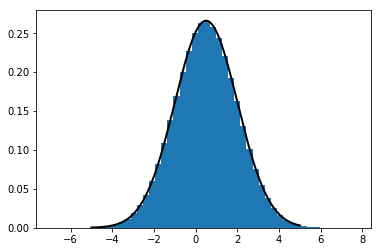

In [10]:
x = np.linspace(-5.0, 5.0, num=10000)
plt.figure(1)

sample_distribution = stats.norm.pdf(x, ret.x[0], ret.x[1])

# Plot histogram of samples
hist_count, bins, _ = plt.hist(data, 50, normed=True) #Norm to keep distribution in view
plt.plot(x, sample_distribution, linewidth=2, color='black')

plt.show()

---

In [11]:
# Example
test_x, test_y = sample_model(model_tf, 50)

In [12]:
print(test_x)
print(test_y)

[-0.33729739  1.06583416  1.18502168  0.68129834  0.27169948 -0.07307988
  2.09521759  1.19116249 -2.6992311  -0.42686769  4.46029173  0.82111575
  2.19121298  0.81589722  0.4104124   0.35021305 -1.7725482   2.10104395
 -1.16246493  2.24060421 -0.22259101  0.15716769  0.92865403  1.33654034
  0.70968291 -2.46653089  1.48370714  4.20501768  1.78805253  0.4615136
  4.06840266  0.05723466  1.67091431  0.68597732 -0.56271742  1.65666754
  2.11648315  3.11680725  1.02679517  0.6420526  -0.46124367  2.28573862
 -0.12653971 -1.10976458  0.84212054 -1.85996423  0.6227112   2.9093652
  0.35202837  1.23789941]
[ 0.21990547  0.1994977   0.15953804  0.10839476  0.26271476  0.22629358
  0.26595762  0.23584467  0.25993509  0.17133268  0.17382749  0.02040382
  0.22962169  0.26594979  0.26443605  0.08399361  0.24806608  0.25947347
  0.11939499  0.25261468  0.12575693  0.12237124  0.22611715  0.14159498
  0.14481888  0.23622513  0.26329192  0.13866789  0.17692679  0.21952614
  0.26064811  0.14222418  0

---

## Fit in SciPy

### Fit using `rv_continuous.fit()`

In [13]:
TYPE = np.float64

# Using the continuous random variable class
# https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.rv_continuous.html
from scipy.stats import rv_continuous
class model_gen(rv_continuous):
    """Normal distribution"""
    def _pdf(self, x):
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)

Show that the fit can work at all

In [14]:
scipy_gaussian = model_gen(name='gaussian')

mu_true = 0.5
sigma_true = 1.5

X = np.random.normal(mu_true, sigma_true, n_events).astype(TYPE)

# Return MLEs for shape, location, and scale parameters from data
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.rv_continuous.fit.html
scipy_ret = scipy_gaussian.fit(X)

print('MLE mean: {}'.format(scipy_ret[0]))
print('MLE standard deviation: {}'.format(scipy_ret[1]))

MLE mean: 0.4984328533411571
MLE standard deviation: 1.5009249170773948


Time the fit

In [15]:
start_time = time.time()

for _ in itertools.repeat(None, n_trials):
    X = np.random.normal(mu_true, sigma_true, n_events).astype(TYPE)
    scipy_ret = scipy_gaussian.fit(X)
    
end_time = time.time()
time_duration = end_time - start_time
mean_fit_time = time_duration/n_trials

print("true mu = {}, true sigma = {}".format(mu_true, sigma_true))
print("MLE mu = {}, MLE sigma = {}".format(scipy_ret[0], scipy_ret[1]))

print("\nfit {} points {} times in {} seconds".format(n_events, n_trials, time_duration))
print("The average fit time is {} seconds".format(mean_fit_time))

true mu = 0.5, true sigma = 1.5
MLE mu = 0.5030657523953337, MLE sigma = 1.4999146467346545

fit 1000000 points 10 times in 77.80968499183655 seconds
The average fit time is 7.780968499183655 seconds


### Fit using `optimize.minimize()`

Define the NLL for our Gaussian model --- the function we want to minimize

In [16]:
def nll(x, data):
    """The negative log likelihood of Normal(X | loc, scale)"""
    loc, scale = x
    return len(data) * np.log(scale) + np.sum((data - loc) ** 2) / (2 * scale ** 2)

Show that the fit can work at all

In [17]:
mu_true = 0.5
sigma_true = 1.5

X = np.random.normal(mu_true, sigma_true, n_events).astype(TYPE)

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
op_ret = op.minimize(nll, x0=[10,10], args=(X), bounds=((None, None), (0.00001, None)))

print('MLE mean: {}'.format(op_ret.x[0]))
print('MLE standard deviation: {}'.format(op_ret.x[1]))

MLE mean: 0.49795909963163215
MLE standard deviation: 1.5003641016819975


Time the fit

In [18]:
start_time = time.time()

for _ in itertools.repeat(None, n_trials):
    X = np.random.normal(mu_true, sigma_true, n_events).astype(TYPE)
    op_ret = op.minimize(nll, x0=[10,10], args=(X), bounds=((None, None), (0.00001, None)))
    
end_time = time.time()
time_duration = end_time - start_time
mean_fit_time = time_duration/n_trials

print("true mu = {}, true sigma = {}".format(mu_true, sigma_true))
print("MLE mu = {}, MLE sigma = {}".format(op_ret.x[0], op_ret.x[1]))

print("\nfit {} points {} times in {} seconds".format(n_events, n_trials, time_duration))
print("The average fit time is {} seconds".format(mean_fit_time))

true mu = 0.5, true sigma = 1.5
MLE mu = 0.49928668175507446, MLE sigma = 1.4985089763712618

fit 1000000 points 10 times in 2.758953809738159 seconds
The average fit time is 0.27589538097381594 seconds


---

## Fit in HistFactory